# Instrução do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará ter um valor F1 de pelo menos 0,85.

## Inicialização

In [1]:
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer  = WordNetLemmatizer()

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carregar Dados

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.dropna(inplace=True)

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

## AED

Vamos verificar o número de filmes e resenhas ao longo dos anos.

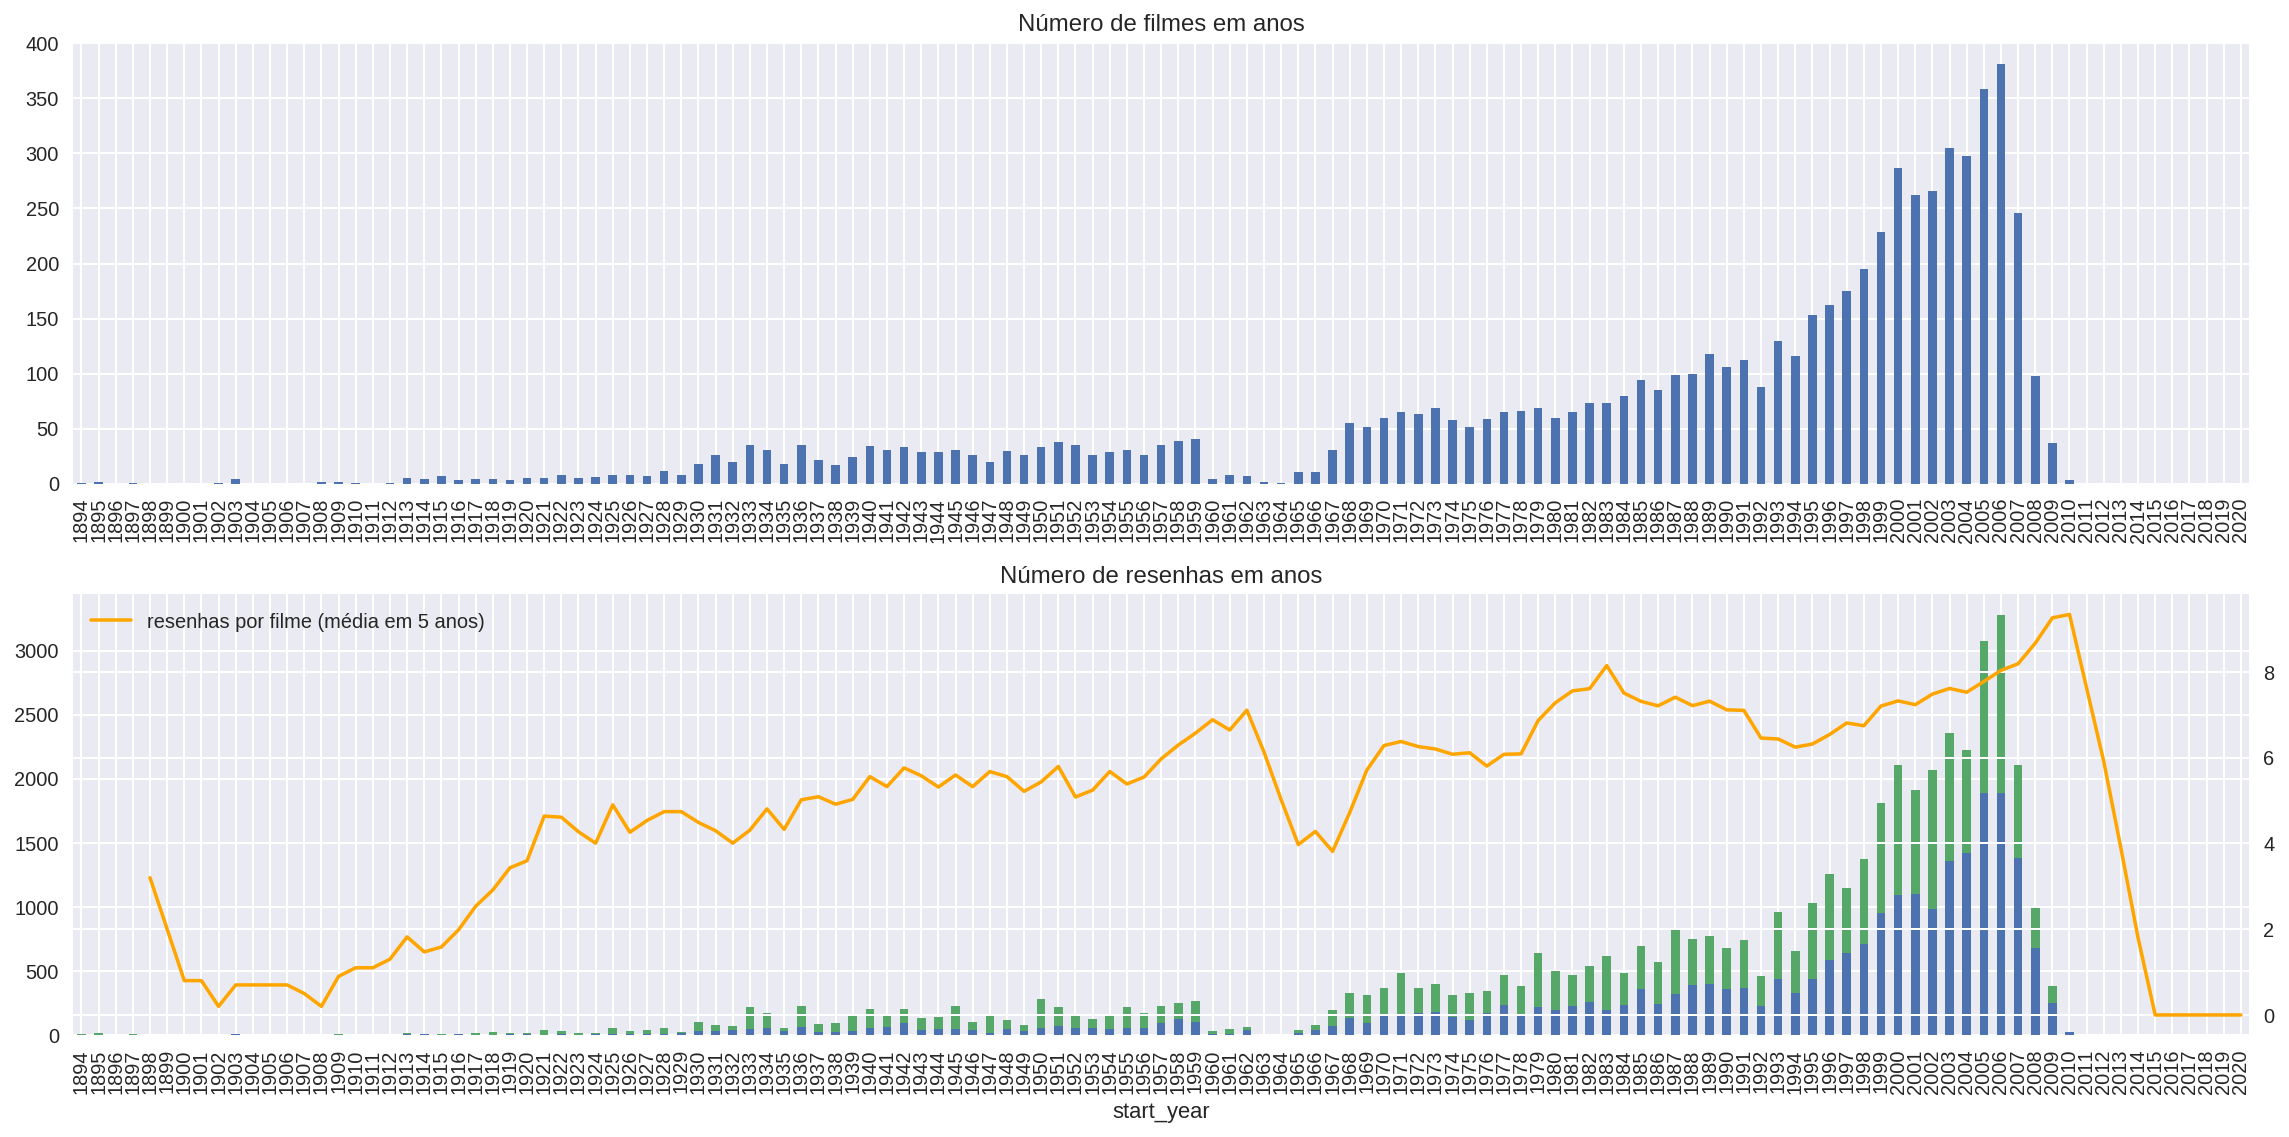

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

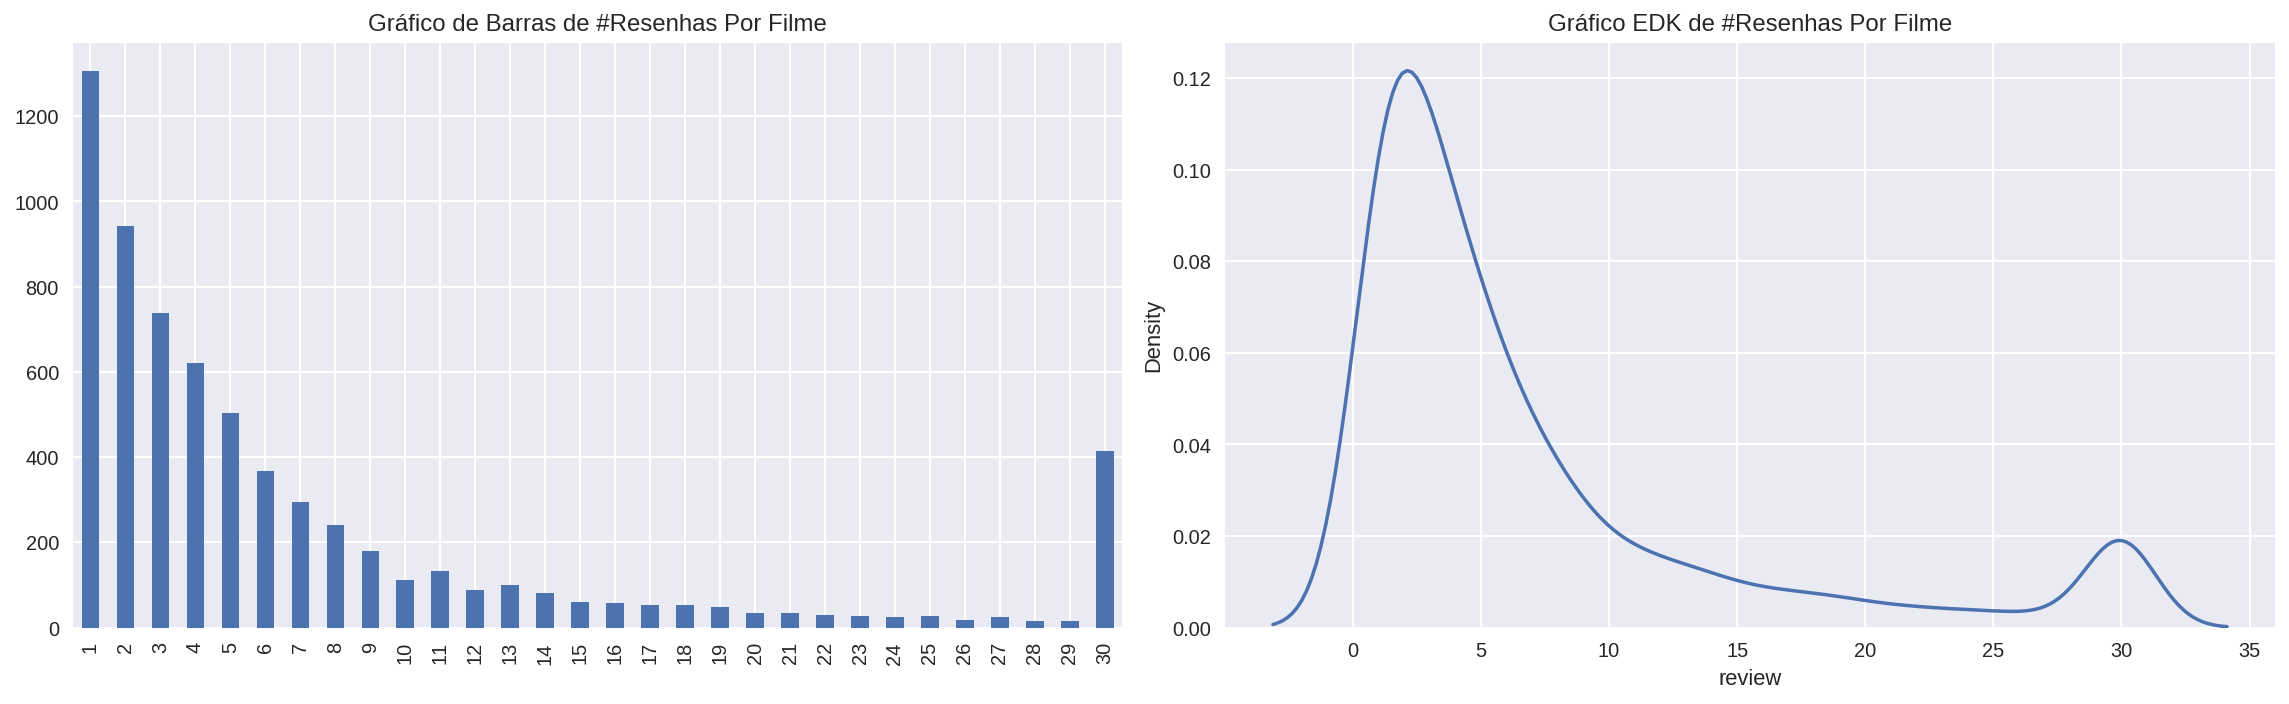

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

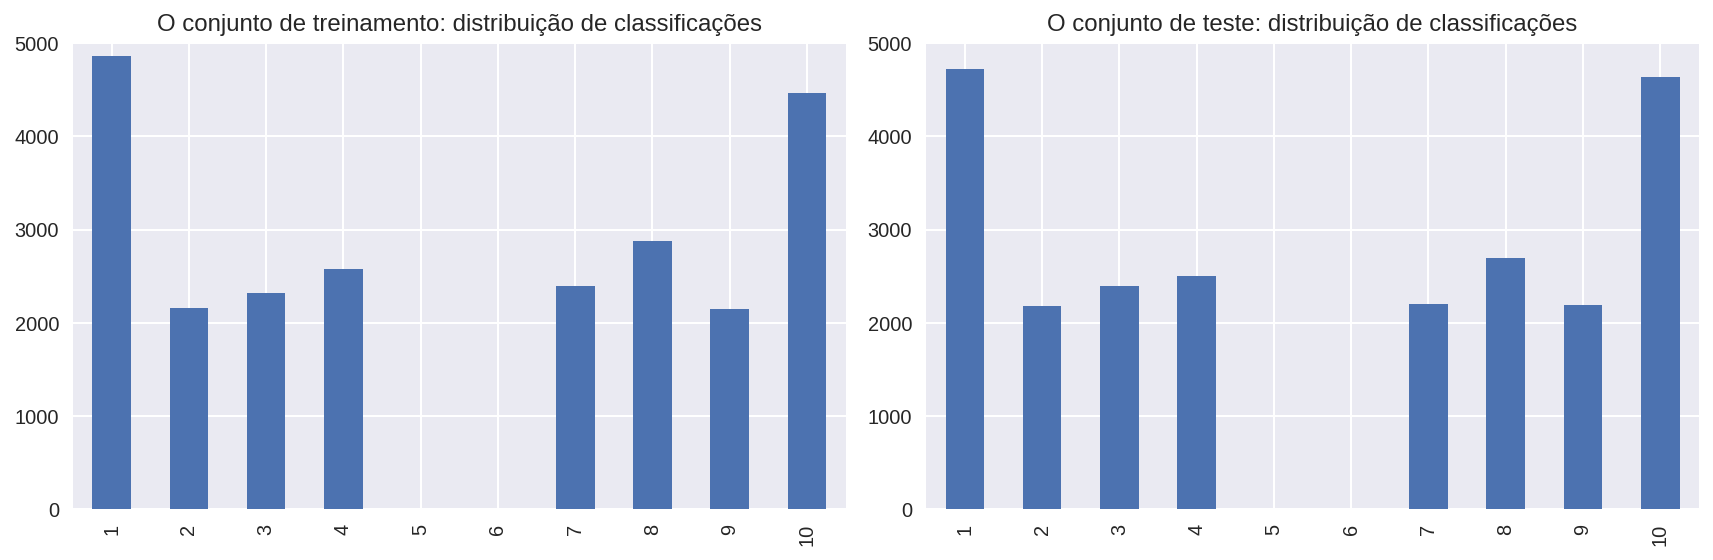

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


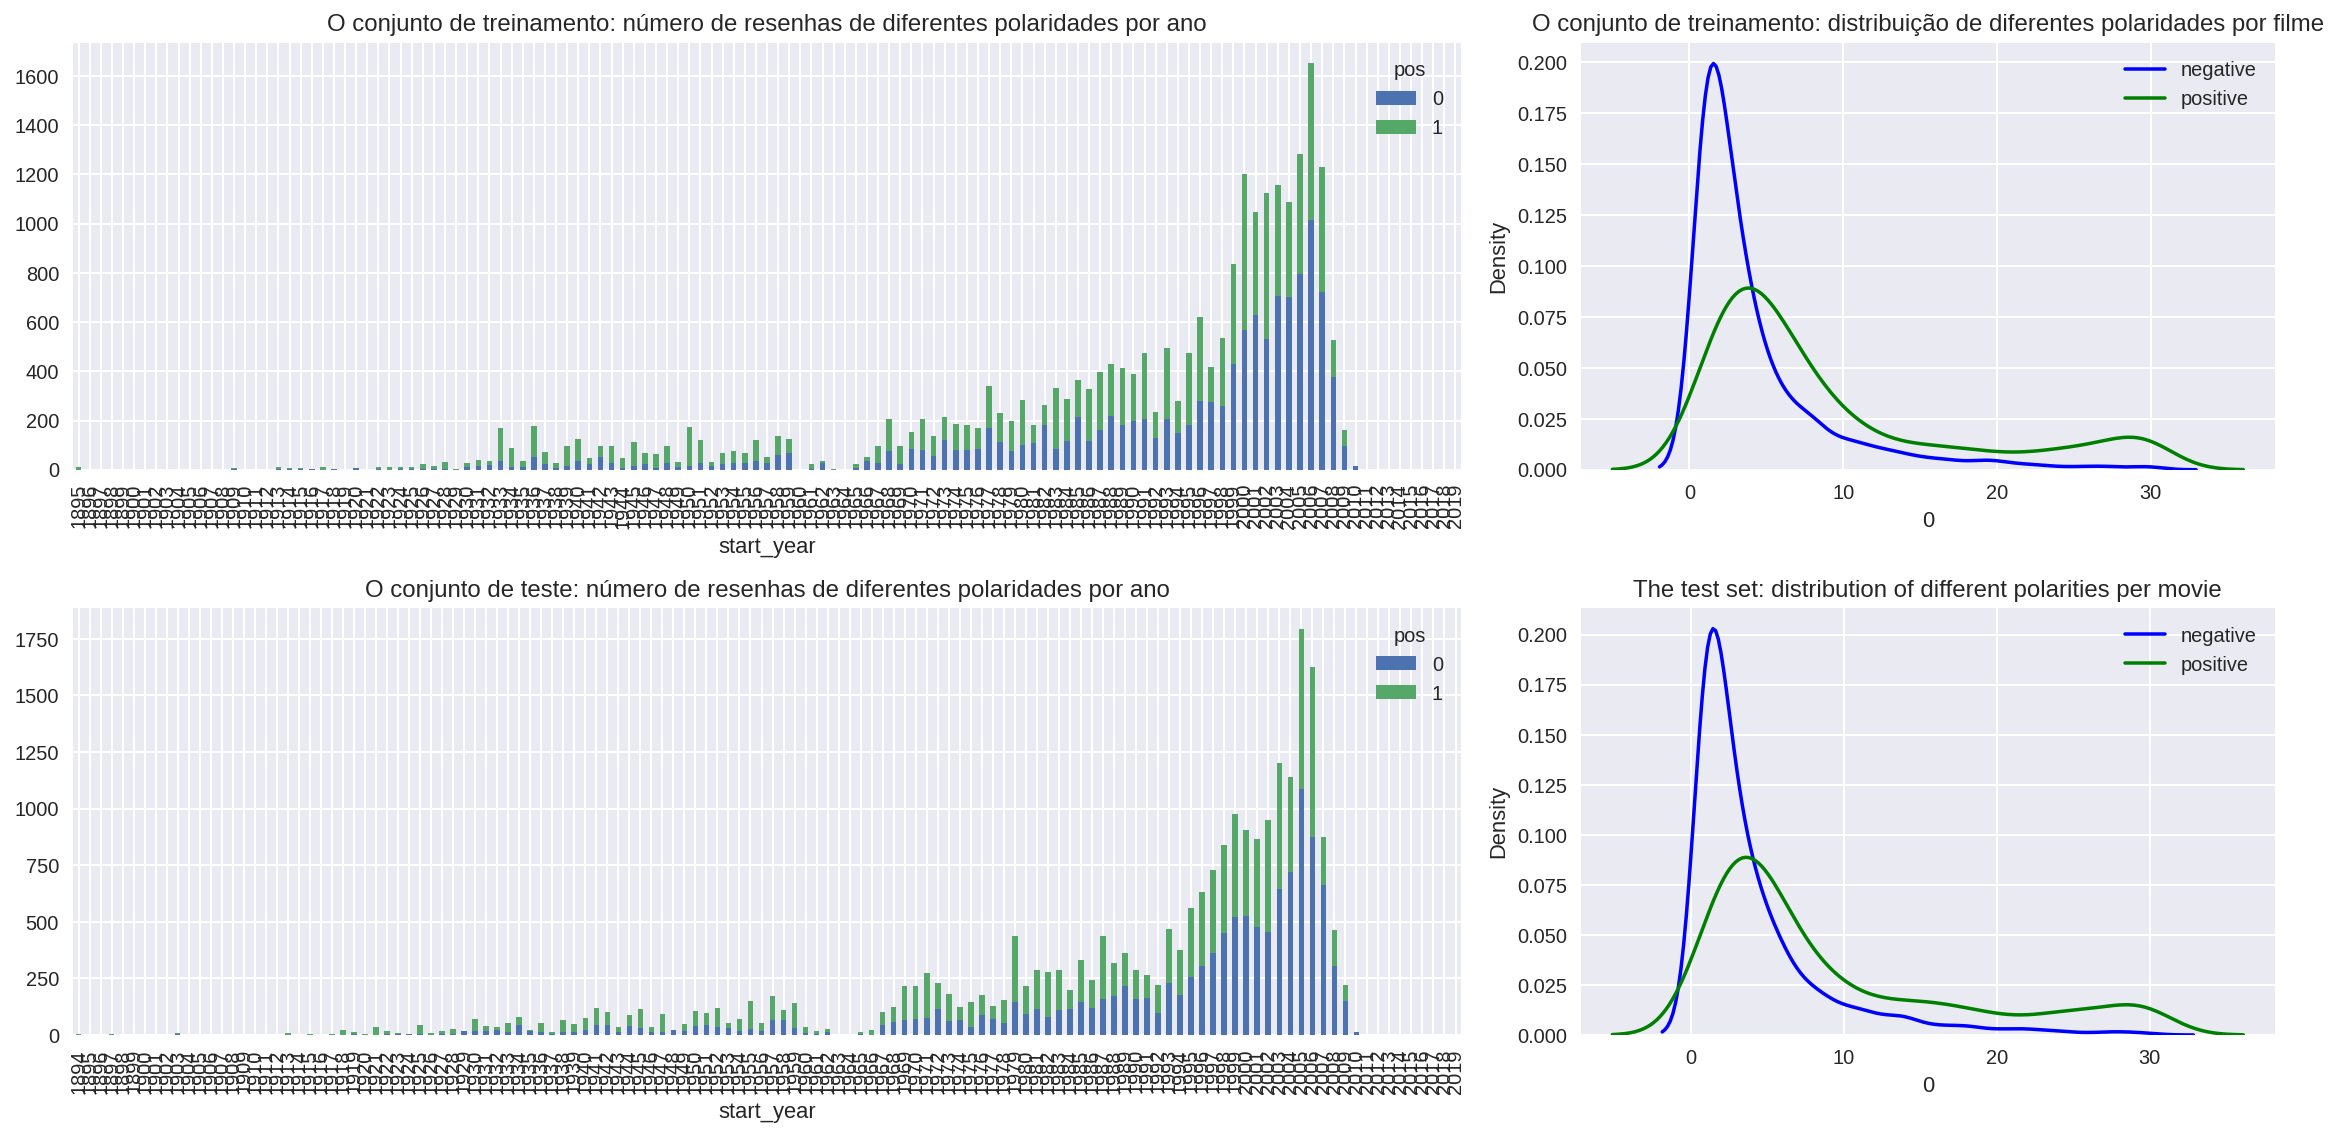

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [69]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Acurácia'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = f1_scores[max_f1_score_idx]
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [14]:
def normalizar_texto(texto):
    # Converter para minúsculas
    texto_normalizado = texto.lower()
    # Remover dígitos, sinais de pontuação e outros caracteres não alfabéticos
    texto_normalizado = re.sub(r'[^a-z\s]', '', texto_normalizado)
    return texto_normalizado

df_reviews['review_norm'] = df_reviews['review'].apply(normalizar_texto)

In [16]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um  a serious film about troubled teens in sin...
4    im totally agree with garryjohal from singapor...
Name: review_norm, dtype: object

## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabalhando com modelos

### Modelo 0 - Constante

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
stop_words=set(nltk_stopwords.words('english'))

In [20]:
X_train_dummy = []
X_test_dummy = []

for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    no_stop_words = [t for t in tokens if not t in stop_words]
    lemmas = [lemmatizer.lemmatize(nsw) for nsw in no_stop_words] 
    X_train_dummy.append(" ".join(lemmas))
    
for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    no_stop_words = [t for t in tokens if not t in stop_words]
    lemmas = [lemmatizer.lemmatize(nsw) for nsw in no_stop_words] 
    X_test_dummy.append(" ".join(lemmas))
    

dummy_model = DummyClassifier().fit(X_train_dummy, train_target)

In [21]:
X_train_dummy = df_reviews_train.drop('pos', axis=1)
X_test_dummy = df_reviews_test.drop('pos', axis=1)
dummy_model = DummyClassifier().fit(X_train_dummy, train_target)

          train  test
Acurácia    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


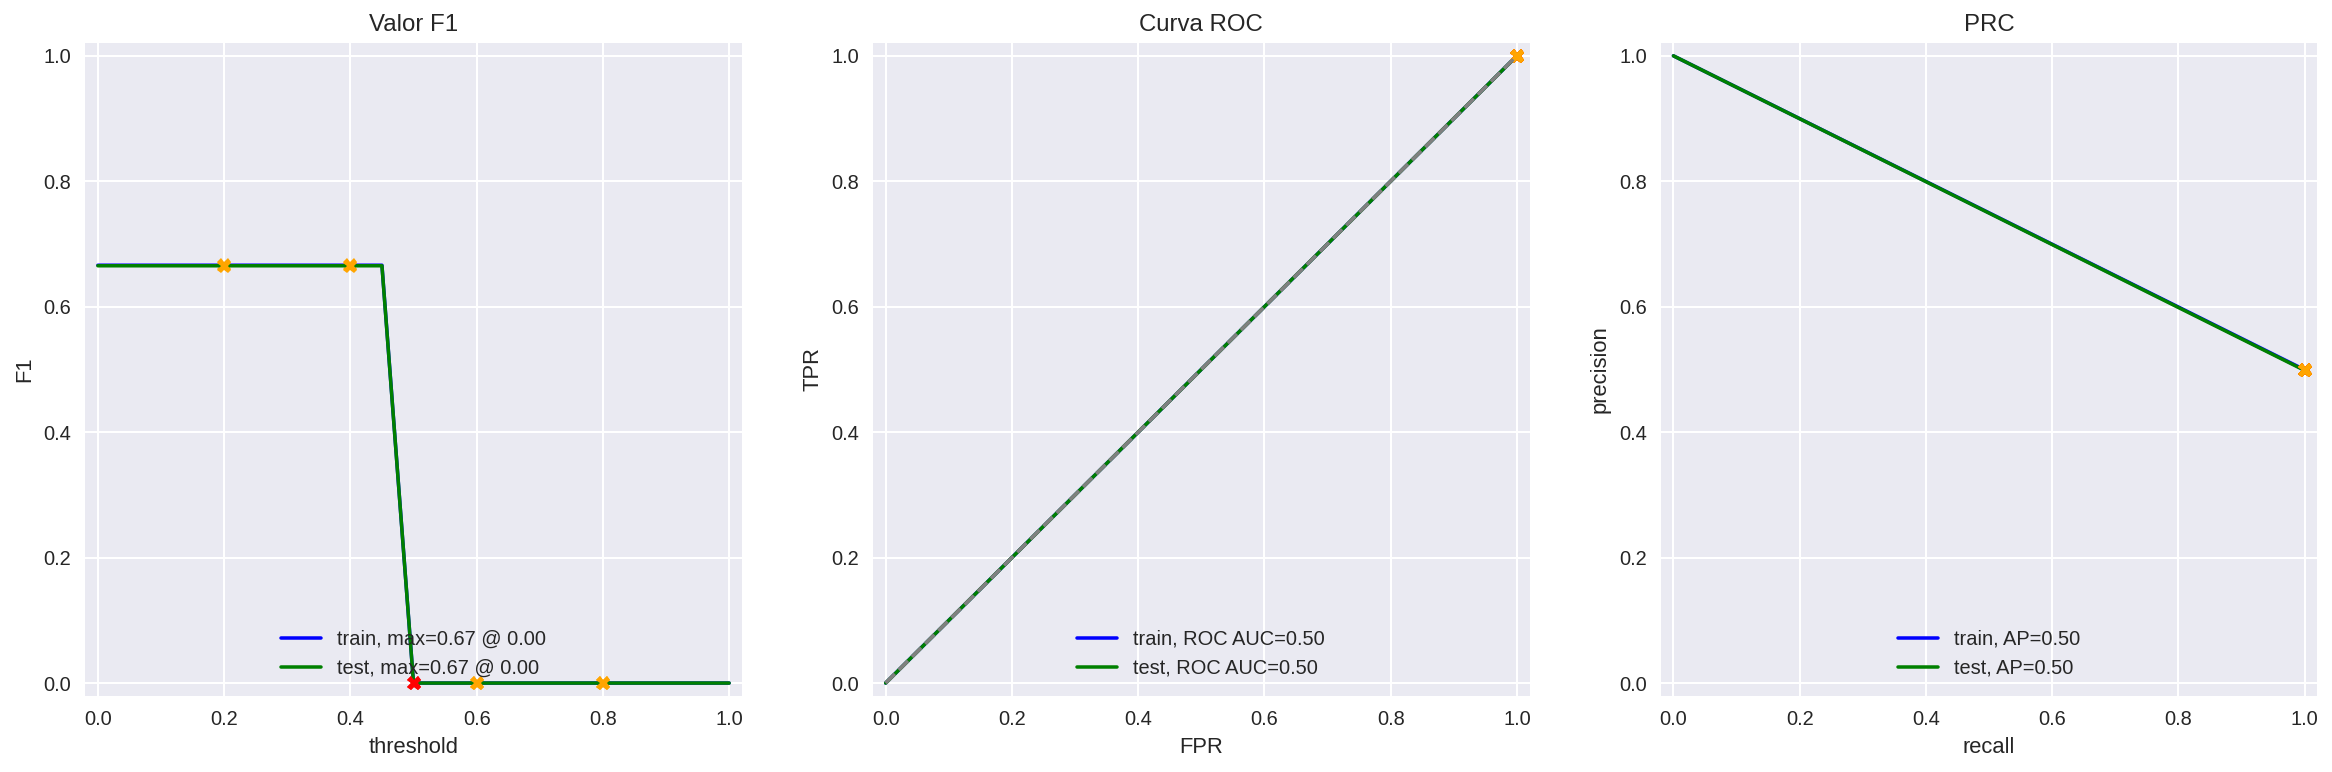

In [68]:
evaluate_model(dummy_model, X_train_dummy, train_target, X_test_dummy, test_target)

### Modelo 1 - NLTK, TF-IDF e Regressão Linear

TF-IDF

In [23]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [24]:
corpus_train = []
corpus_test = []

for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    #no_stop_words = [t for t in tokens if not t in stop_words]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens] 
    corpus_train.append(" ".join(lemmas))
    
for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    #no_stop_words = [t for t in tokens if not t in stop_words]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens] 
    corpus_test.append(" ".join(lemmas))

In [25]:
corpus = df_reviews_train['review_norm']
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
tfidf_1 = tfidf_vectorizer_1.fit_transform(corpus_train)

print('O tamanho da matriz TF-IDF:', tfidf_1.shape)

O tamanho da matriz TF-IDF: (23796, 96817)


In [26]:
train_features_1 = tfidf_1

test_features_1 = tfidf_vectorizer_1.transform(corpus_test)

model_1 = LogisticRegression().fit(train_features_1, train_target)

          train  test
Acurácia   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


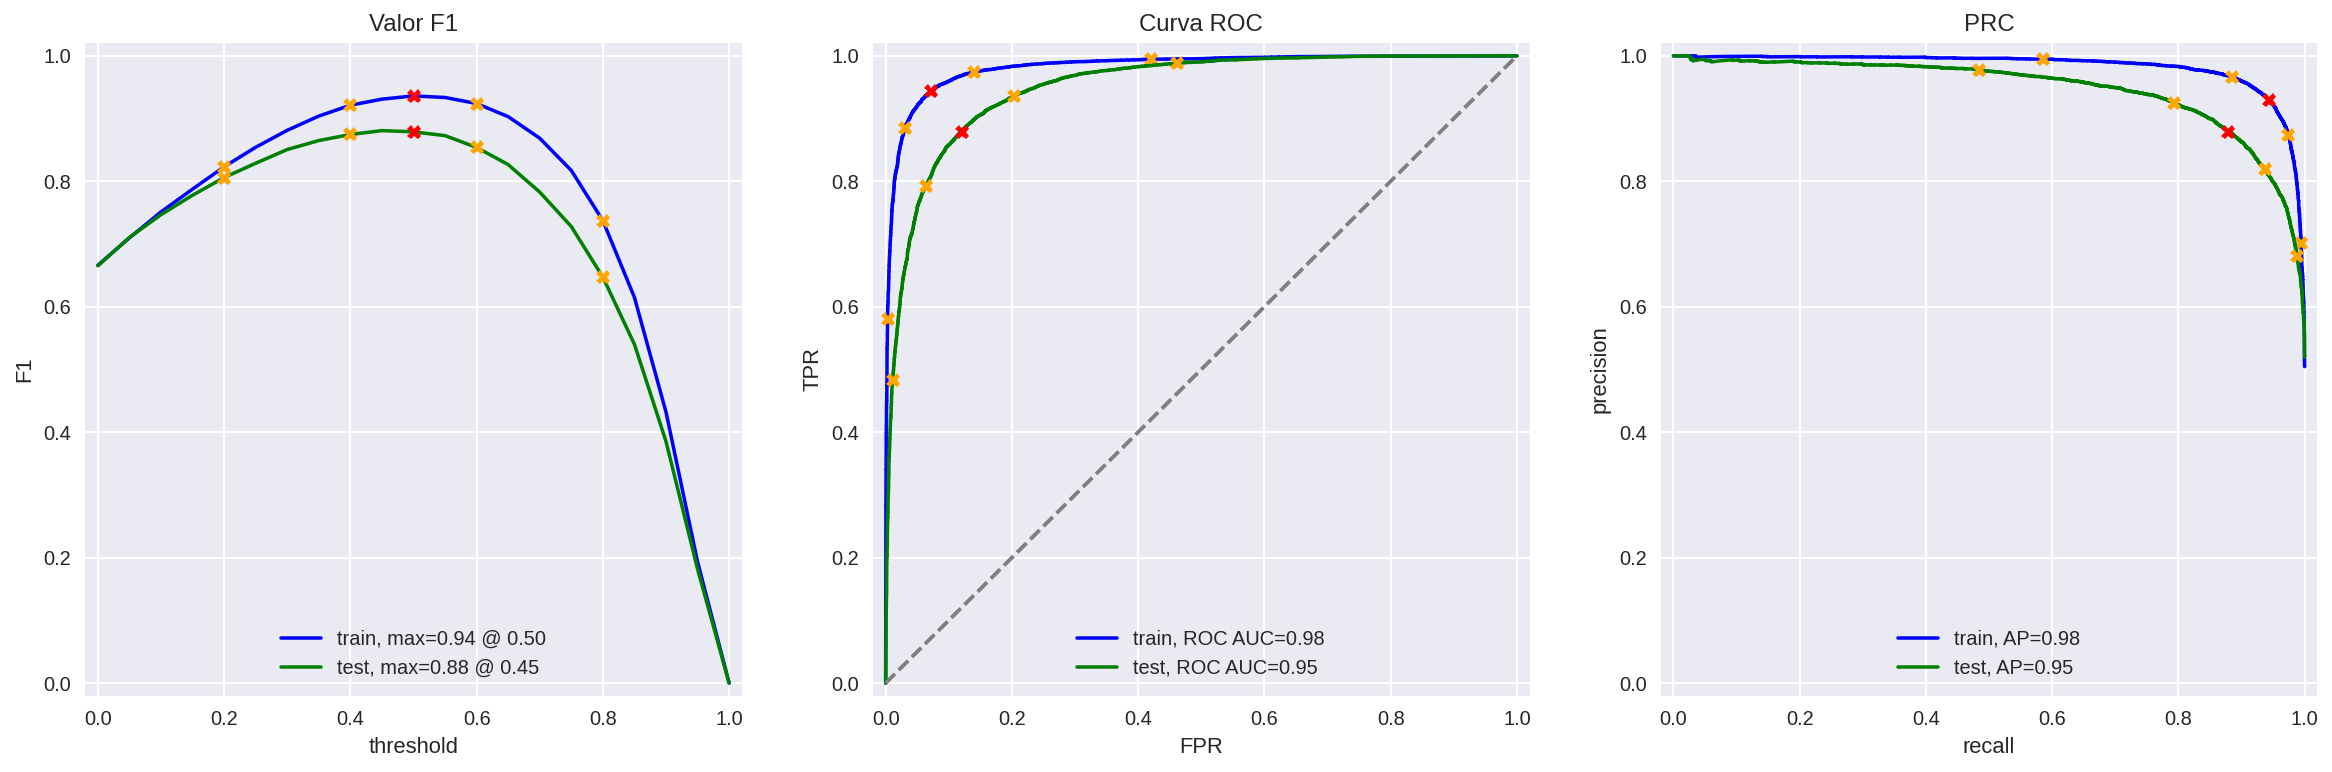

In [70]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF e Regressão Linear

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [76]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [30]:
train_corpus = df_reviews_train['review_norm'].apply(text_preprocessing_3)

In [31]:
test_corpus = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [32]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)
tfidf_3 = tfidf_vectorizer_3.fit_transform(train_corpus)

print('O tamanho da matriz TF-IDF:', tfidf_3.shape)

O tamanho da matriz TF-IDF: (23796, 91187)


In [33]:
train_features_3 = tfidf_3

test_features_3 = tfidf_vectorizer_3.transform(test_corpus)

model_3 = LogisticRegression().fit(train_features_3, train_target)

          train  test
Acurácia   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


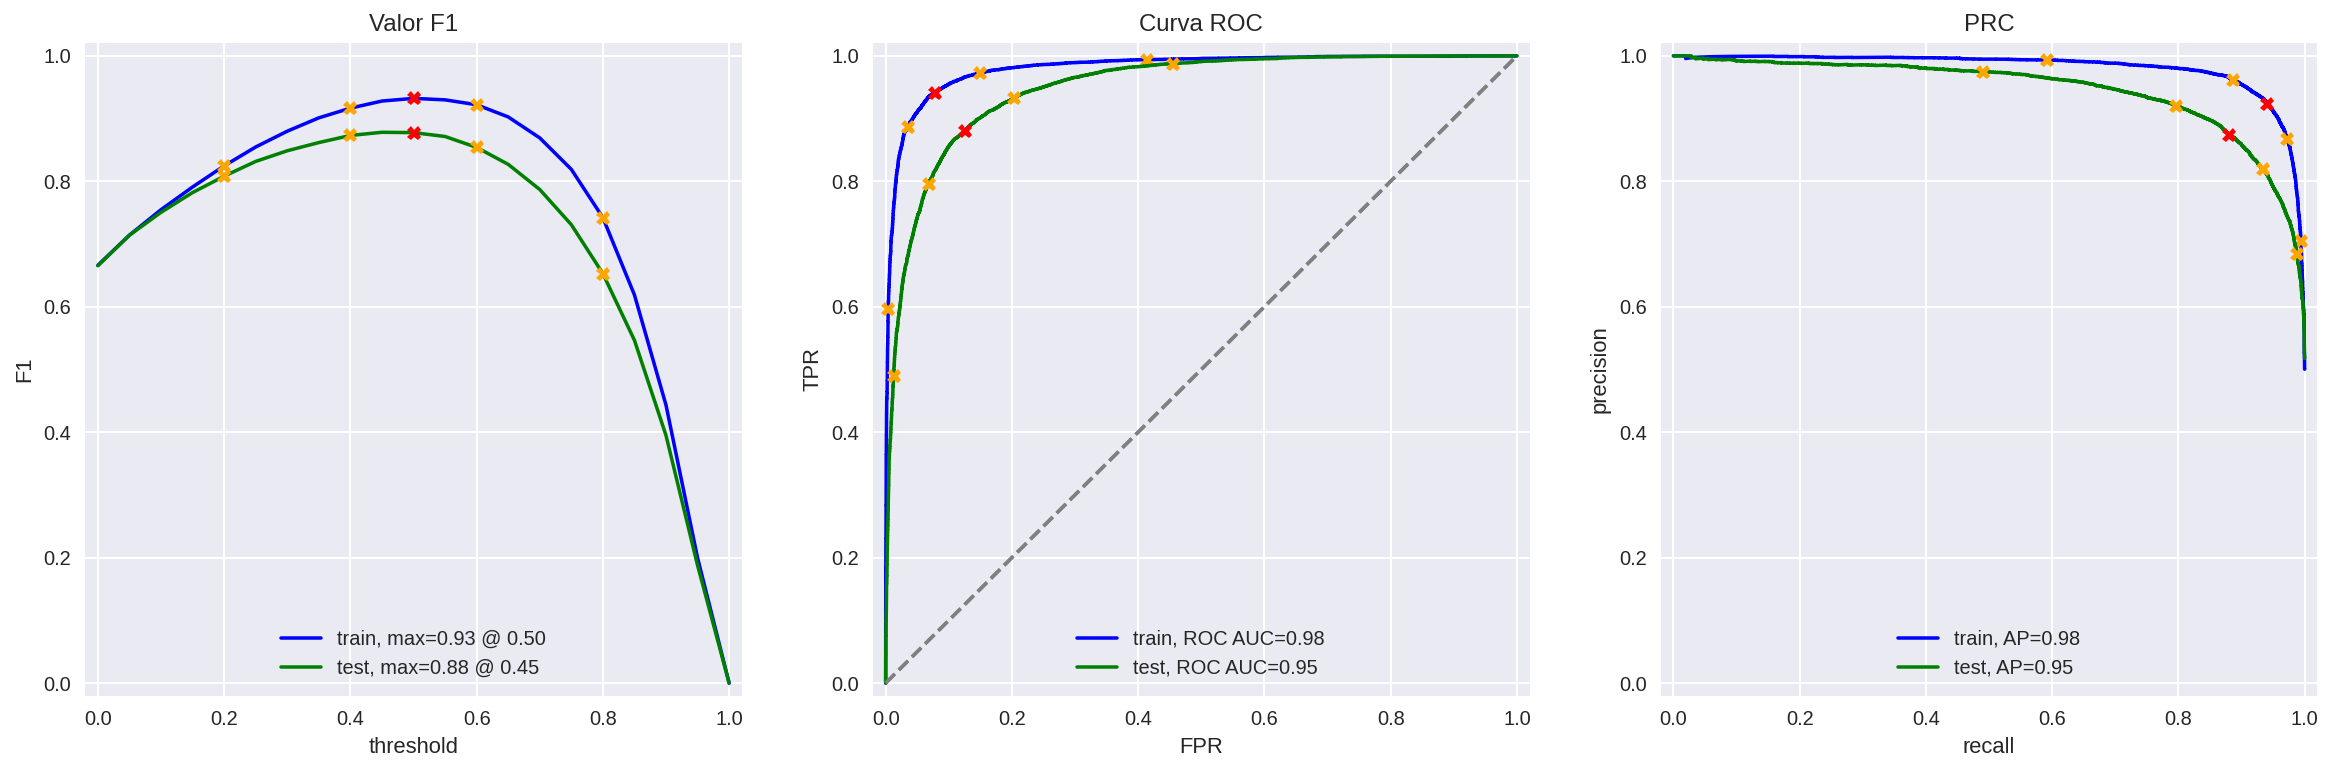

In [67]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - SpaCy, TF-IDF e LGBMClassifier

In [35]:
from lightgbm import LGBMClassifier

In [36]:
# Utilizando o tf_idf do modelo anterior o utilizando apenas o LGBMClassifier
train_features_4 = train_features_3

test_features_4 = test_features_3

model_4 = LGBMClassifier().fit(train_features_4, train_target)

          train  test
Acurácia   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


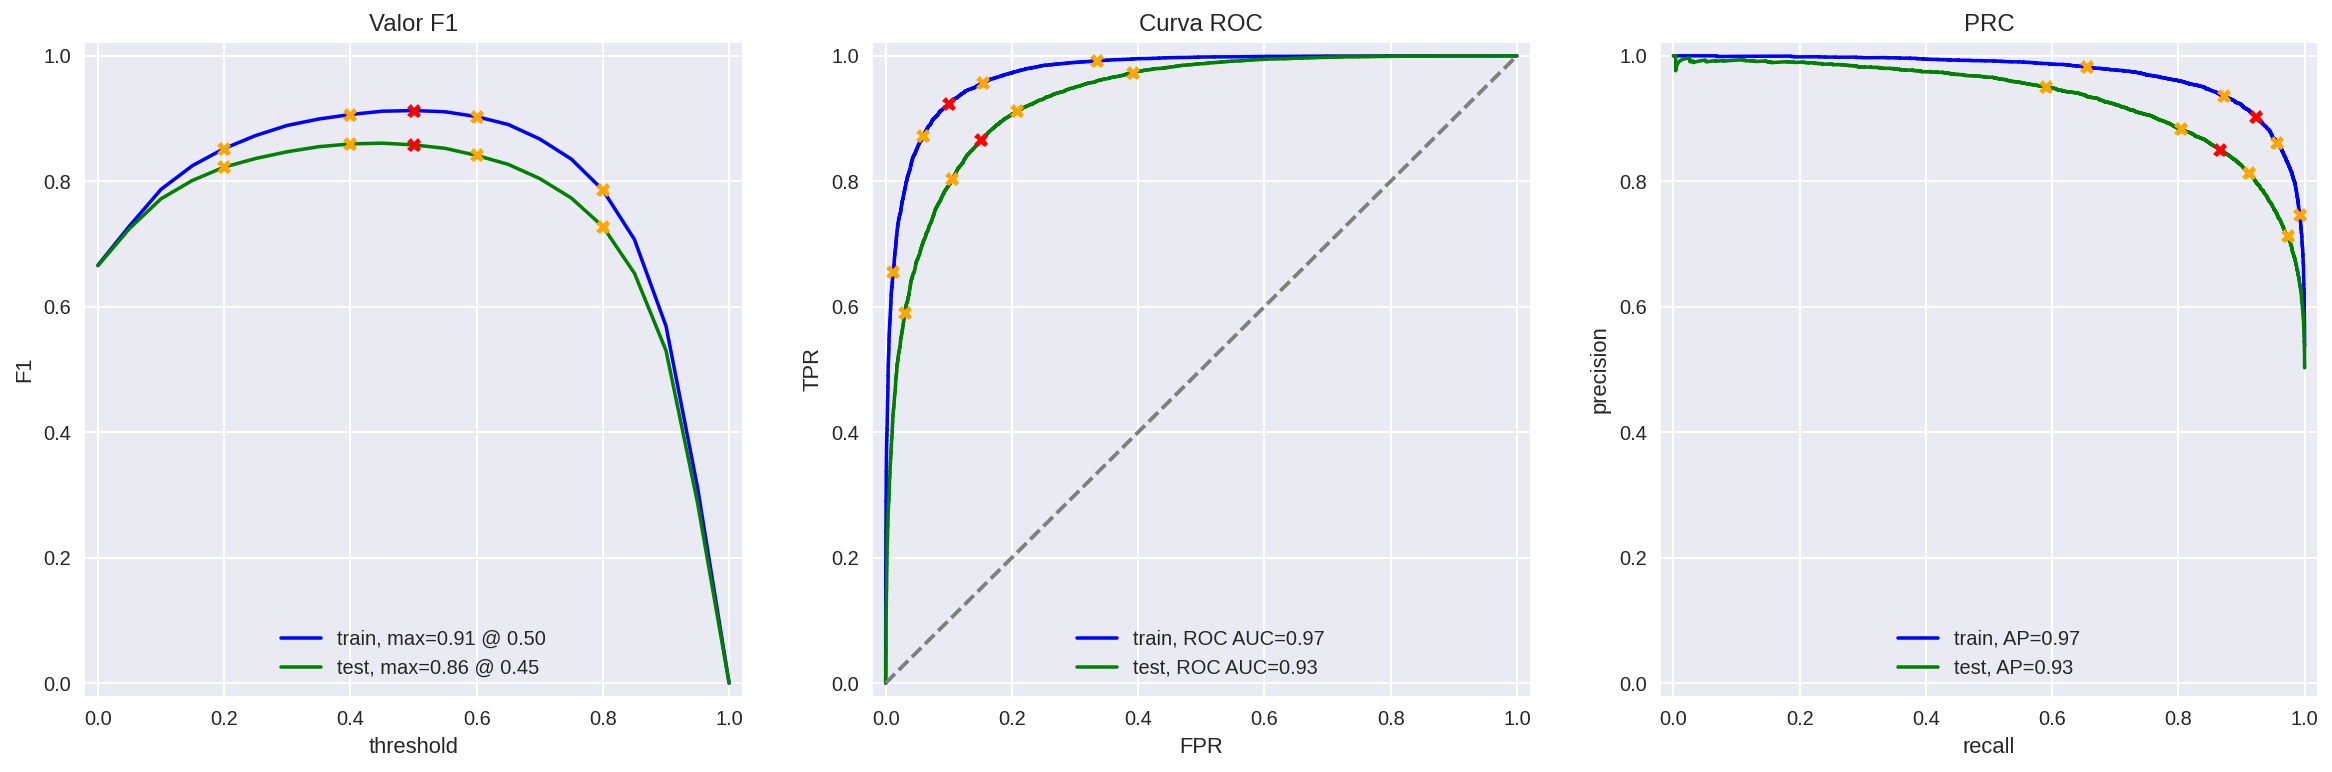

In [71]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

###  Modelo 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto para IDs de tokens preenchidos com suas máscaras de atenção
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    
    # <coloque seu código aqui para criar ids_list e attention_mask_list>
    for text in texts:
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        n = 512
        padded = np.array(ids[:n] + [0]*(n - len(ids)))

        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(ids)
        attention_mask_list.append(attention_mask)     
        
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Usando o dispositivo {device}.')
    
    # recebendo incorporações em lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <coloque seu código aqui para criar attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Atenção! A execução do BERT para milhares de textos pode levar muito tempo na CPU, pelo menos várias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device= 'cuda')

<div class="alert alert-block alert-warning">
<b>Comentário do revisor: </b> <a class="tocSkip"></a>

É quase inviável rodar sem placa de vídeo. Orietno desconsiderar essa parte de BERT
</div>

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# se você tiver as incorporações, é aconselhável salvá-las para tê-las prontas se 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# e carregar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [ ]:
# Salvar
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

In [ ]:
# Carregar
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

## Minhas Resenhas

In [ ]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame([
    'Eu simplesmente não gostei, não é meu tipo de filme.',
    'Bem, eu fiquei entediado e dormi no meio do filme.',
    'Eu fiquei realmente fascinado com o filme',    
    'Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do filme. Que roubo de dinheiro sem vergonha.',
    'Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o material original',
    'O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar indo assistir novamente.',
    'Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhenta, nem crianças não vão gostar disso!',
    'Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após episódio, deste emocionante e inteligente novo drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalizar_texto)


my_reviews

In [38]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame([
    'I just didnt like it, it is not my kind of movie.',
    'Well, i got bored and slept in the middle of the movie.',
    'I was really fascinated by the movie',    
    'The actors looked really old and uninterested, and they were still paid to participate in the film. What a shameless steal of money.',
    'I did not expect the new version to be so good! THe writers really cared about the source material',
    'The movie has its pros e cons, but i fell that after all is a decent movie. I can imagine myself watching it again.',
    'What a poor attempt at comedy. Not even a single joke works, everybody acts annoying and loud , not even children will like that!',
    'Release on Netflix was a bold move and i actually apreciate be able to watch episode after episode of this new exciting and intelligent drama'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalizar_texto)
#my_reviews['review_norm']=my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())
#my_reviews['review_norm']=my_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))

my_reviews

,review,review_norm
0,"I just didnt like it, it is not my kind of movie.",i just didnt like it it is not my kind of movie
1,"Well, i got bored and slept in the middle of t...",well i got bored and slept in the middle of th...
2,I was really fascinated by the movie,i was really fascinated by the movie
3,"The actors looked really old and uninterested,...",the actors looked really old and uninterested ...
4,I did not expect the new version to be so good...,i did not expect the new version to be so good...
5,"The movie has its pros e cons, but i fell that...",the movie has its pros e cons but i fell that ...
6,What a poor attempt at comedy. Not even a sing...,what a poor attempt at comedy not even a singl...
7,Release on Netflix was a bold move and i actua...,release on netflix was a bold move and i actua...


### Modelo 1

In [77]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i just didnt like it it is not my kind of movie
0.38:  well i got bored and slept in the middle of the movie
0.60:  i was really fascinated by the movie
0.30:  the actors looked really old and uninterested and they were still paid to participate in the film wh
0.44:  i did not expect the new version to be so good the writers really cared about the source material
0.17:  the movie has its pros e cons but i fell that after all is a decent movie i can imagine myself watch
0.00:  what a poor attempt at comedy not even a single joke works everybody acts annoying and loud  not eve
0.93:  release on netflix was a bold move and i actually apreciate be able to watch episode after episode o


### Modelo 3

In [78]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.34:  i just didnt like it it is not my kind of movie
0.09:  well i got bored and slept in the middle of the movie
0.62:  i was really fascinated by the movie
0.14:  the actors looked really old and uninterested and they were still paid to participate in the film wh
0.26:  i did not expect the new version to be so good the writers really cared about the source material
0.29:  the movie has its pros e cons but i fell that after all is a decent movie i can imagine myself watch
0.01:  what a poor attempt at comedy not even a single joke works everybody acts annoying and loud  not eve
0.91:  release on netflix was a bold move and i actually apreciate be able to watch episode after episode o


### Modelo 4

In [79]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  i just didnt like it it is not my kind of movie
0.44:  well i got bored and slept in the middle of the movie
0.60:  i was really fascinated by the movie
0.41:  the actors looked really old and uninterested and they were still paid to participate in the film wh
0.66:  i did not expect the new version to be so good the writers really cared about the source material
0.59:  the movie has its pros e cons but i fell that after all is a decent movie i can imagine myself watch
0.10:  what a poor attempt at comedy not even a single joke works everybody acts annoying and loud  not eve
0.71:  release on netflix was a bold move and i actually apreciate be able to watch episode after episode o


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusões

Considerando apenas os modelos 1 (NTLK, Regressão Linear), 3 (spaCy, Regressão Linear) e 4 (spaCy, LGBM), o modelo 1 teve melhores acurácia e F1 no conjunto treino, atigindo valor de 0.94 nos dois indicadores, seguido pelo modelo 3, com 0.93 e o 4 com 0.91, apesar da valores maiores e menores todos atingiram um valor maior que 0.85 o que satisfaz a condição estabelecida no início do projeto. Para o conjunto de teste a ordem se mantém a mesma com os modelo 1 e 3 com 0.88 e o modelo 4 com 0.86 nos dois indicadores.

Ao submeter as resenhas personalizadas aos modelos, os modelos 1 e 3 tem variações maiores e acertam de forma geral, mas ao verificarmos as notas para duas resenhas 5 e 6 eles deram uma nota baixa que classificaria as resenhas como negativas, porém são resenhas positivias. O modelo 4 classifica elas de forma mais próxima da realidade, porém não consegue captar a intensidade da crítica negativa e positiva.

# Checklist

- [x]  O caderno foi aberto
- [x]  Os dados de texto são carregados e pré-processados para vetorização
- [x]  Os dados de texto são transformados em vetores
- [x]  Os modelos são treinados e testados
- [x]  O limiar da métrica foi atingido
- [x]  Todas as células de código estão organizadas na ordem de sua execução
- [x]  Todas as células de código podem ser executadas sem erros
- [x]  Há conclusões 